In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import warnings
warnings.filterwarnings("ignore")

In [23]:
paths=[]
lables=[]
for dirname,_,filenames in os.walk("TESS Toronto emotional speech set data"):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        lables.append(filename.split("_")[-1].split(".")[0])

In [40]:
data=pd.DataFrame({"Path":paths,"Label":lables})

In [27]:
data['lables'].value_counts()

lables
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

In [54]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

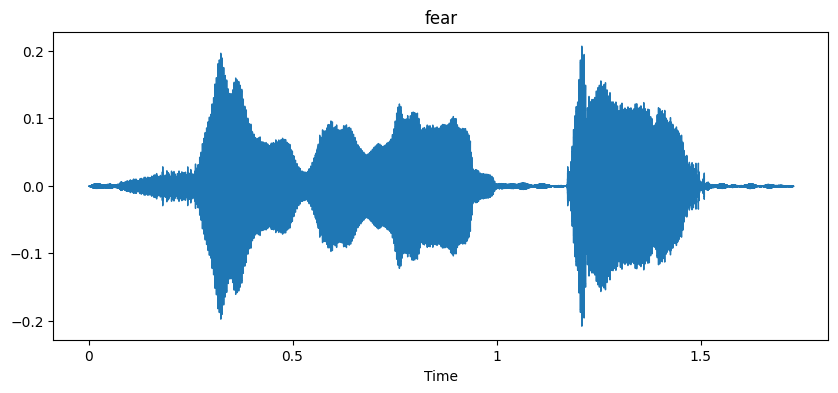

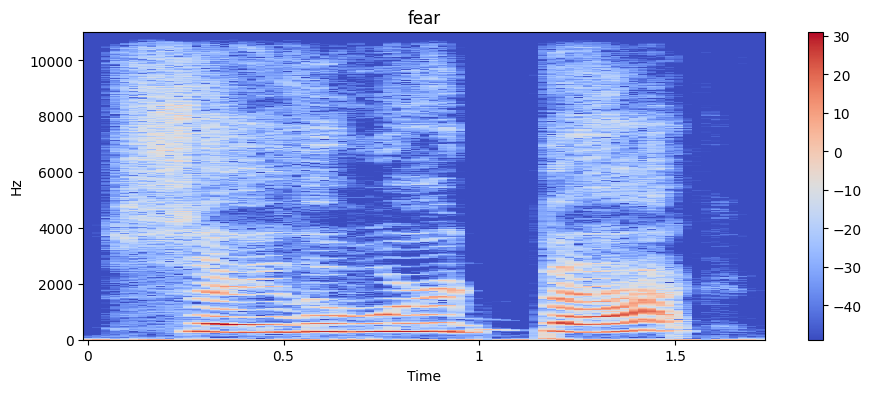

In [55]:
emotion="fear"
path=(data['Path'][data['Label']==emotion]).iloc[0]
audio_data,sampling_rate=librosa.load(path)
waveplot(audio_data,sampling_rate,emotion)
spectogram(audio_data,sampling_rate,emotion)

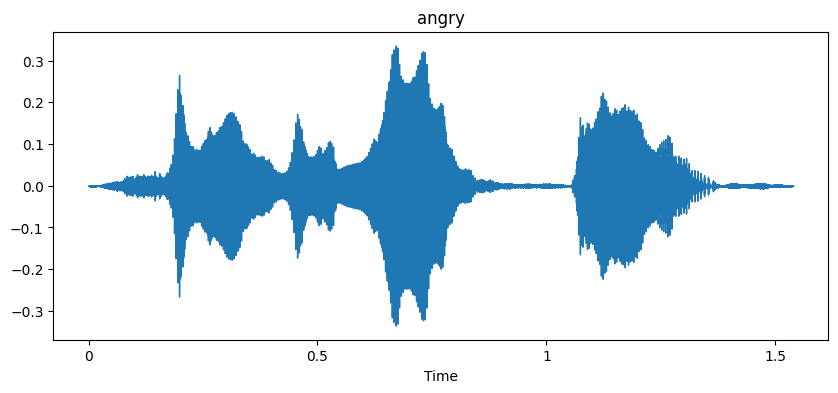

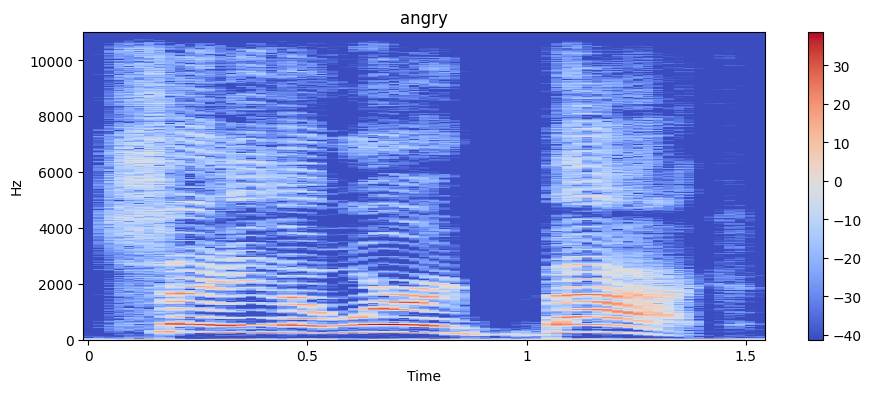

In [56]:
emotion="angry"
path=(data['Path'][data['Label']==emotion]).iloc[0]
audio_data,sampling_rate=librosa.load(path)
waveplot(audio_data,sampling_rate,emotion)
spectogram(audio_data,sampling_rate,emotion)

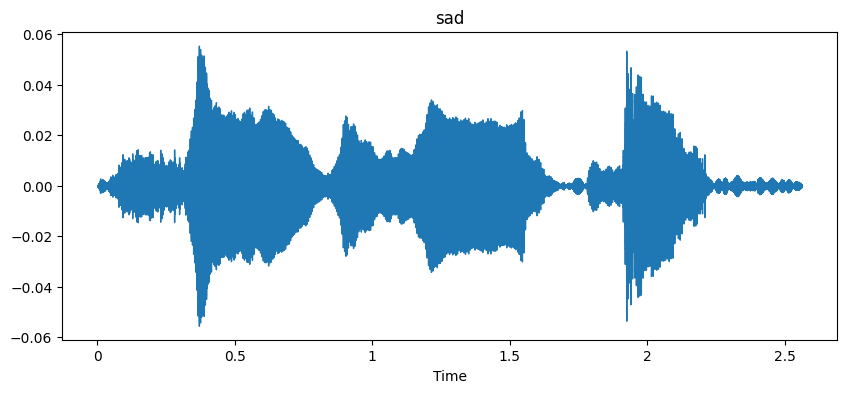

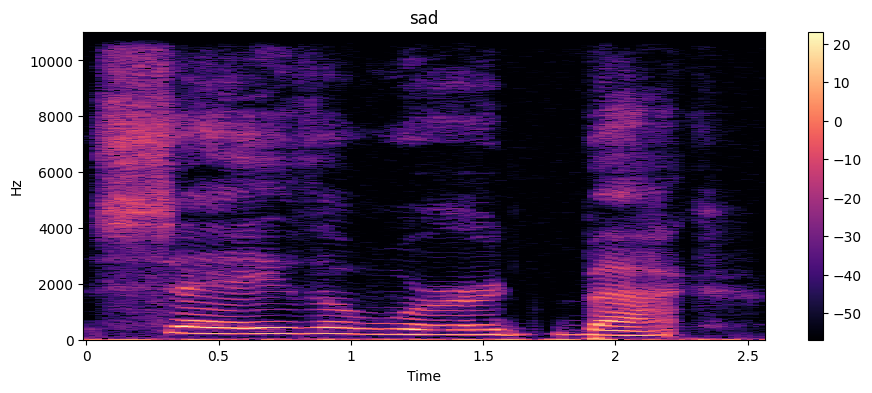

In [57]:
emotion="sad"
path=(data['Path'][data['Label']==emotion]).iloc[0]
audio_data,sampling_rate=librosa.load(path)
waveplot(audio_data,sampling_rate,emotion)
spectogram(audio_data,sampling_rate,emotion)

In [60]:
def extract_mfcc(filename):
    y,sr=librosa.load(filename,duration=4,offset=0.2)
    mfcc=np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=50).T,axis=0)
    return mfcc

In [65]:
X_mfcc=data['Path'].apply(lambda x:extract_mfcc(x))

In [66]:
X_mfcc

0       [-377.46982, 66.04187, -21.009771, -16.646233,...
1       [-442.067, 79.35285, -4.803243, -25.093107, -8...
2       [-399.5074, 34.56943, -6.6013427, -1.5540946, ...
3       [-380.11975, 66.40203, -14.25253, -18.271885, ...
4       [-398.95572, 62.85215, 1.7729615, 8.237238, 7....
                              ...                        
5595    [-389.81314, 72.485725, 31.397772, 46.359158, ...
5596    [-405.64206, 92.68556, 21.702932, 43.761604, 0...
5597    [-367.02808, 76.58386, 34.64246, 43.63109, -6....
5598    [-419.18417, 79.601074, 27.090244, 40.42004, -...
5599    [-407.17404, 63.195843, 30.523558, 43.55403, 2...
Name: Path, Length: 5600, dtype: object

In [70]:
X=[x for x in X_mfcc]
X=np.array(X)
X=np.expand_dims(X,-1)
X

array([[[-3.7746982e+02],
        [ 6.6041870e+01],
        [-2.1009771e+01],
        ...,
        [ 3.2932475e+00],
        [-8.2942408e-01],
        [ 4.2035413e+00]],

       [[-4.4206699e+02],
        [ 7.9352852e+01],
        [-4.8032432e+00],
        ...,
        [ 4.8043447e+00],
        [ 2.6149874e+00],
        [ 6.8578939e+00]],

       [[-3.9950739e+02],
        [ 3.4569431e+01],
        [-6.6013427e+00],
        ...,
        [ 4.2298064e+00],
        [ 4.6839099e+00],
        [ 1.2911029e+01]],

       ...,

       [[-3.6702808e+02],
        [ 7.6583862e+01],
        [ 3.4642460e+01],
        ...,
        [-3.5539070e-01],
        [ 1.6597141e-01],
        [ 4.5506353e+00]],

       [[-4.1918417e+02],
        [ 7.9601074e+01],
        [ 2.7090244e+01],
        ...,
        [-1.6606793e+00],
        [-2.3392386e+00],
        [ 2.9020612e+00]],

       [[-4.0717404e+02],
        [ 6.3195843e+01],
        [ 3.0523558e+01],
        ...,
        [-7.1893865e-01],
        [-2.944

In [80]:
enc=OneHotEncoder()
y=enc.fit_transform(data[['Label']])

In [81]:
y=y.toarray()

In [85]:
X.shape

(5600, 50, 1)

In [87]:
model=Sequential([
    LSTM(128,return_sequences=False,input_shape=(50,1)),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
])

In [92]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 77127 (301.28 KB)
Trainable params: 7712

In [94]:
history=model.fit(X,y,validation_split=0.2,epochs=20,batch_size=64,shuffle=True)

Epoch 1/20
70/70 [==============================] - 5s 40ms/step - loss: 1.2607 - accuracy: 0.5042 - val_loss: 0.7672 - val_accuracy: 0.6786
Epoch 2/20
70/70 [==============================] - 2s 33ms/step - loss: 0.4561 - accuracy: 0.8429 - val_loss: 0.2089 - val_accuracy: 0.9527
Epoch 3/20
70/70 [==============================] - 2s 34ms/step - loss: 0.2692 - accuracy: 0.9212 - val_loss: 0.1404 - val_accuracy: 0.9643
Epoch 4/20
70/70 [==============================] - 2s 33ms/step - loss: 0.1914 - accuracy: 0.9424 - val_loss: 0.0957 - val_accuracy: 0.9732
Epoch 5/20
70/70 [==============================] - 2s 33ms/step - loss: 0.1445 - accuracy: 0.9574 - val_loss: 0.1007 - val_accuracy: 0.9714
Epoch 6/20
70/70 [==============================] - 2s 36ms/step - loss: 0.1235 - accuracy: 0.9652 - val_loss: 0.0620 - val_accuracy: 0.9848
Epoch 7/20
70/70 [==============================] - 3s 44ms/step - loss: 0.0849 - accuracy: 0.9786 - val_loss: 0.1025 - val_accuracy: 0.9732
Epoch 8/20
70

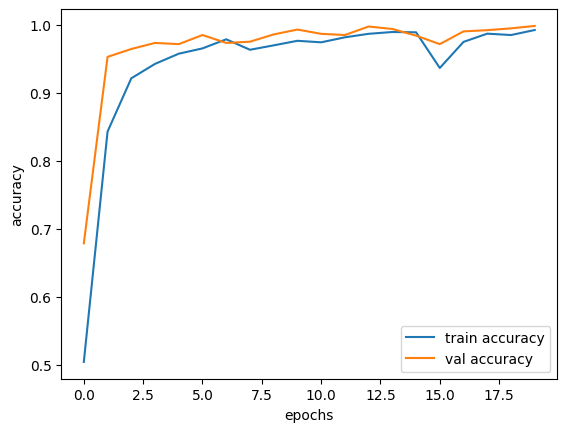

In [95]:

epochs = list(range(20))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

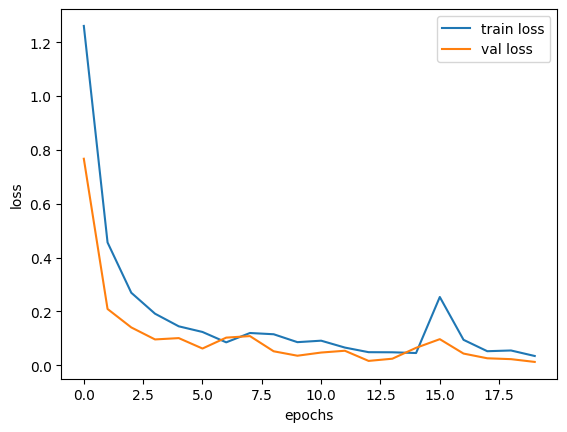

In [96]:

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [100]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
